In [22]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from scipy import stats
%matplotlib inline
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.decomposition import PCA
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import classification_report

from sklearn.base import clone
from itertools import combinations
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.manifold import TSNE


#scaling
from sklearn.preprocessing import StandardScaler

#Preprocessing
from sklearn import preprocessing

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection


In [23]:
df = pd.read_csv("data/data.csv", header=0)
df = df.rename(columns={"Unnamed: 0": "Patient ID"})


In [24]:
df.head()

,Patient ID,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
1,sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
2,sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
3,sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
4,sample_4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Columns: 20532 entries, Patient ID to gene_20530
dtypes: float64(20531), object(1)
memory usage: 125.5+ MB


In [26]:
df.shape , df.size

((801, 20532), 16446132)

In [27]:
df_label = pd.read_csv("./data/labels.csv", header=0)
df_label = df_label.rename(columns={"Unnamed: 0": "Patient ID"})
df_label.head()

,Patient ID,Class
0,sample_0,PRAD
1,sample_1,LUAD
2,sample_2,PRAD
3,sample_3,PRAD
4,sample_4,BRCA


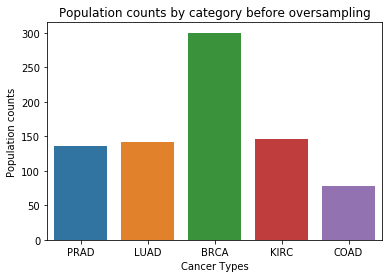

In [53]:
sns.countplot(df_label['Class']).set_title("Population counts by category before oversampling")
plt.xlabel("Cancer Types")
plt.ylabel("Population counts")
plt.show()

In [29]:
df.describe()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
count,801.000000,801.000000,801.000000,801.000000,801.000000,801.0,801.000000,801.000000,801.000000,801.000000,...,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000
mean,0.026642,3.010909,3.095350,6.722305,9.813612,0.0,7.405509,0.499882,0.016744,0.013428,...,5.896573,8.765891,10.056252,4.847727,9.741987,11.742228,10.155271,9.590726,5.528177,0.095411
std,0.136850,1.200828,1.065601,0.638819,0.506537,0.0,1.108237,0.508799,0.133635,0.204722,...,0.746399,0.603176,0.379278,2.382728,0.533898,0.670371,0.580569,0.563849,2.073859,0.364529
min,0.000000,0.000000,0.000000,5.009284,8.435999,0.0,3.930747,0.000000,0.000000,0.000000,...,2.853517,6.678368,8.669456,0.000000,7.974942,9.045255,7.530141,7.864533,0.593975,0.000000
25%,0.000000,2.299039,2.390365,6.303346,9.464466,0.0,6.676042,0.000000,0.000000,0.000000,...,5.454926,8.383834,9.826027,3.130750,9.400747,11.315857,9.836525,9.244219,4.092385,0.000000
50%,0.000000,3.143687,3.127006,6.655893,9.791599,0.0,7.450114,0.443076,0.000000,0.000000,...,5.972582,8.784144,10.066385,5.444935,9.784524,11.749802,10.191207,9.566511,5.218618,0.000000
75%,0.000000,3.883484,3.802534,7.038447,10.142324,0.0,8.121984,0.789354,0.000000,0.000000,...,6.411292,9.147136,10.299025,6.637412,10.082269,12.177852,10.578561,9.917888,6.876382,0.000000
max,1.482332,6.237034,6.063484,10.129528,11.355621,0.0,10.718190,2.779008,1.785592,4.067604,...,7.771054,11.105431,11.318243,9.207495,11.811632,13.715361,11.675653,12.813320,11.205836,5.254133


In [30]:
df_label.describe()

,Patient ID,Class
count,801,801
unique,801,5
top,sample_231,BRCA
freq,1,300


In [31]:
print('Number of training patients: {}'.format(len(df)))

Number of training patients: 801


In [32]:
print('Percantage of Each Tumor: \n{}'.format(df_label['Class'].value_counts(normalize = True)*100))

Percantage of Each Tumor: 
BRCA    37.453184
KIRC    18.227216
LUAD    17.602996
PRAD    16.978777
COAD     9.737828
Name: Class, dtype: float64


In [33]:
df.isnull().sum().sum()


0

In [34]:
df = df.assign(Class = pd.Series(df_label['Class'].values))

In [35]:
a = df.shape
a = a[0] * a[1]
b = (df != 0).sum(1).sum()
sparsity = 1 - (b/a)
sparsity*100

14.216170273205343

In [36]:
labelenc = preprocessing.LabelEncoder()
labelenc.fit(df['Class'].unique())
labelenc.classes_



array(['BRCA', 'COAD', 'KIRC', 'LUAD', 'PRAD'], dtype=object)

In [37]:
labelenc.inverse_transform([0, 1, 2, 3, 4])
df['Class'] = labelenc.transform(df['Class'])

In [38]:
s = df['Class'].unique()
s.sort()
s

array([0, 1, 2, 3, 4])

In [79]:
df.iloc[:, 1:-1].head()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


In [81]:
X = np.array(df.iloc[:, 1:-1].values)
y = np.array(df.iloc[:, -1].values) 

In [82]:
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [83]:
print('Original dataset shape %s' % Counter(y_train))

Original dataset shape Counter({0: 210, 2: 108, 4: 95, 3: 94, 1: 53})


## Oversampling using Synthetic Minority Over-sampling Technique (SMOTE)

In [84]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy ='auto', k_neighbors=5, random_state = 1)
              
X_res, y_res = smote.fit_resample(X_train, y_train)
              
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 210, 4: 210, 3: 210, 2: 210, 1: 210})


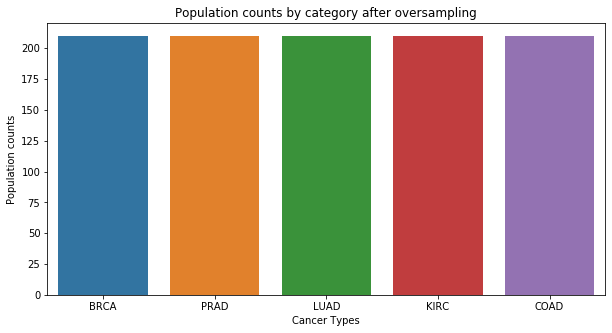

In [87]:
plt.figure(figsize=(10, 5))
sns.countplot(labelenc.inverse_transform(y_res)).set_title("Population counts by category after oversampling")
plt.xlabel("Cancer Types")
plt.ylabel("Population counts")
plt.show()

In [88]:
stdsc = StandardScaler()

X_train = stdsc.fit_transform(X_res)
X_test = stdsc.transform(X_test)
y_train = y_res

## Calculating feature importances using Random Forest Classifier

In [89]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=1500, n_jobs=3)
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1500,
                       n_jobs=3, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [91]:
print("Training accuracy:", rnd_clf.score(X_train, y_train)*100)
print("Test accuracy:", rnd_clf.score(X_test, y_test)*100)

Training accuracy: 100.0
Test accuracy: 99.1701244813278


In [108]:
list_features = sorted(zip(rnd_clf.feature_importances_, df.columns), reverse=True, key = lambda x: x[0])
top_features = {}
for row in list_features[:20]:
    top_features[row[1]] = row[0]
print("Top 20 features list and their importances:")
list_features[:20]

Top 20 features list and their importances:


[(0.005480568607982157, 'gene_18745'),
 (0.004886542544202102, 'gene_7237'),
 (0.004728327980849644, 'gene_3439'),
 (0.00466785779242984, 'gene_15897'),
 (0.004662438167075753, 'gene_11448'),
 (0.004506351033841952, 'gene_11909'),
 (0.00446008399204881, 'gene_7963'),
 (0.0043799471235712855, 'gene_9176'),
 (0.004289810859235188, 'gene_6874'),
 (0.004243453737478302, 'gene_7895'),
 (0.0041471574236614135, 'gene_2036'),
 (0.004126429378327754, 'gene_9174'),
 (0.004003238041453492, 'gene_14797'),
 (0.003928738871064431, 'gene_8013'),
 (0.003916839744732945, 'gene_3522'),
 (0.0039017151732655252, 'gene_15894'),
 (0.003882029353152396, 'gene_1509'),
 (0.0038575551936678824, 'gene_15590'),
 (0.003738671485447973, 'gene_202'),
 (0.0035424201401010216, 'gene_12994')]

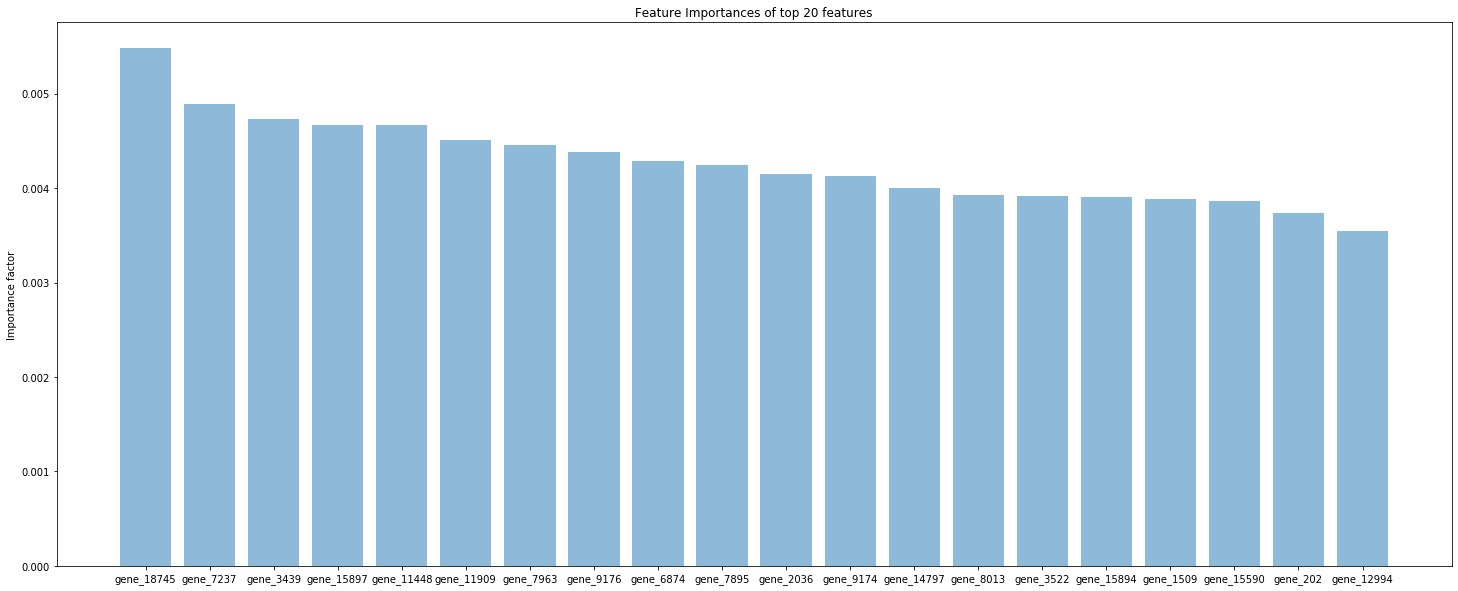

In [112]:
plt.figure(figsize=(25, 10))
plt.bar(top_features.keys(), top_features.values(), align='center', alpha=0.5)
plt.ylabel('Importance factor')
plt.title('Feature Importances of top 20 features')
plt.show()

## Correlation Heatmap of Top 20 Important Features

Text(0.5, 1, 'Correlation heatmap for the top 20 important features')

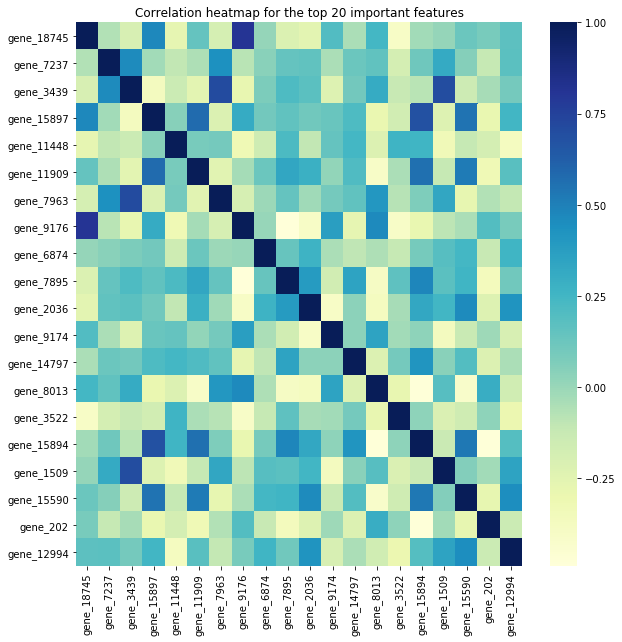

In [113]:
corr = df[top_features.keys()].corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr,cmap="YlGnBu").set_title("Correlation heatmap for the top 20 important features")


In [131]:
def plotvector(X_train, y_train, X_test, y_test):
    results = []
    max1 = 0
    max2 = 0
    
    for i in range(1, 15):
        pipe_xgb = Pipeline([('pca', PCA(n_components=i, random_state=1)),
                     ('clf', DecisionTreeClassifier())])
        
        pipe_xgb.fit(X_train, y_train)
        if(max1<pipe_xgb.score(X_test, y_test)):
            max1 = pipe_xgb.score(X_test, y_test)
            max2 = i
        results.append([i, pipe_xgb.score(X_test, y_test)])
    return np.array(results),max2





In [132]:
PCA_accuracy,max1 =  plotvector(X_train, y_train, X_test, y_test)

In [133]:
PCA_accuracy, max1

(array([[ 1.        ,  0.41078838],
        [ 2.        ,  0.82572614],
        [ 3.        ,  0.88381743],
        [ 4.        ,  0.8879668 ],
        [ 5.        ,  0.94190871],
        [ 6.        ,  0.95435685],
        [ 7.        ,  0.94605809],
        [ 8.        ,  0.94190871],
        [ 9.        ,  0.93360996],
        [10.        ,  0.95020747],
        [11.        ,  0.94605809],
        [12.        ,  0.93360996],
        [13.        ,  0.95435685],
        [14.        ,  0.92946058]]), 6)

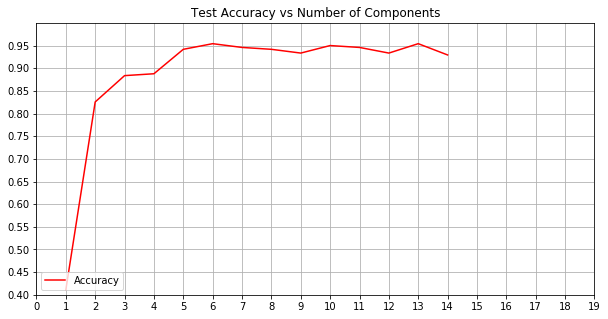

In [135]:
plt.figure(figsize=(10, 5))
plt.plot(PCA_accuracy[:,0], PCA_accuracy[:,1], color='r', label='Accuracy')
plt.legend(loc=3)
plt.ylim(0.4, 1.0)
plt.xlim(0,15)
plt.xticks(np.arange(0, 20, 1.0))
plt.yticks(np.arange(0.4, 1, 0.05))
plt.title("Test Accuracy vs Number of Components")
plt.grid(True)
plt.show()

In [136]:
pca = PCA(n_components=max1)
principal_component = pca.fit_transform(X_train)

In [137]:
principal_df = pd.DataFrame(data=principal_component)
y_train_pca = pd.DataFrame(data = y_train, columns = ["Class"])
concat_df = pd.concat([principal_df, y_train_pca], axis=1)

C:\Users\HotPrada\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


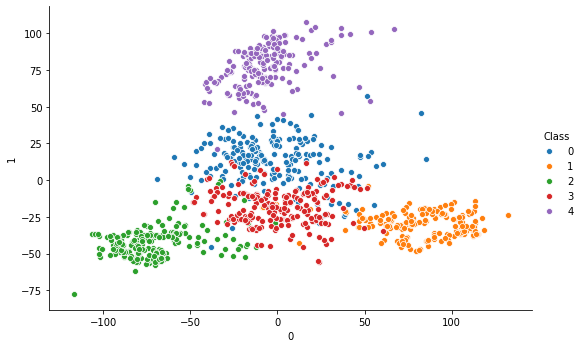

In [30]:
sns.pairplot(x_vars = 0, y_vars = 1,data=concat_df, hue="Class",size=5,aspect=1.5)
plt.show()

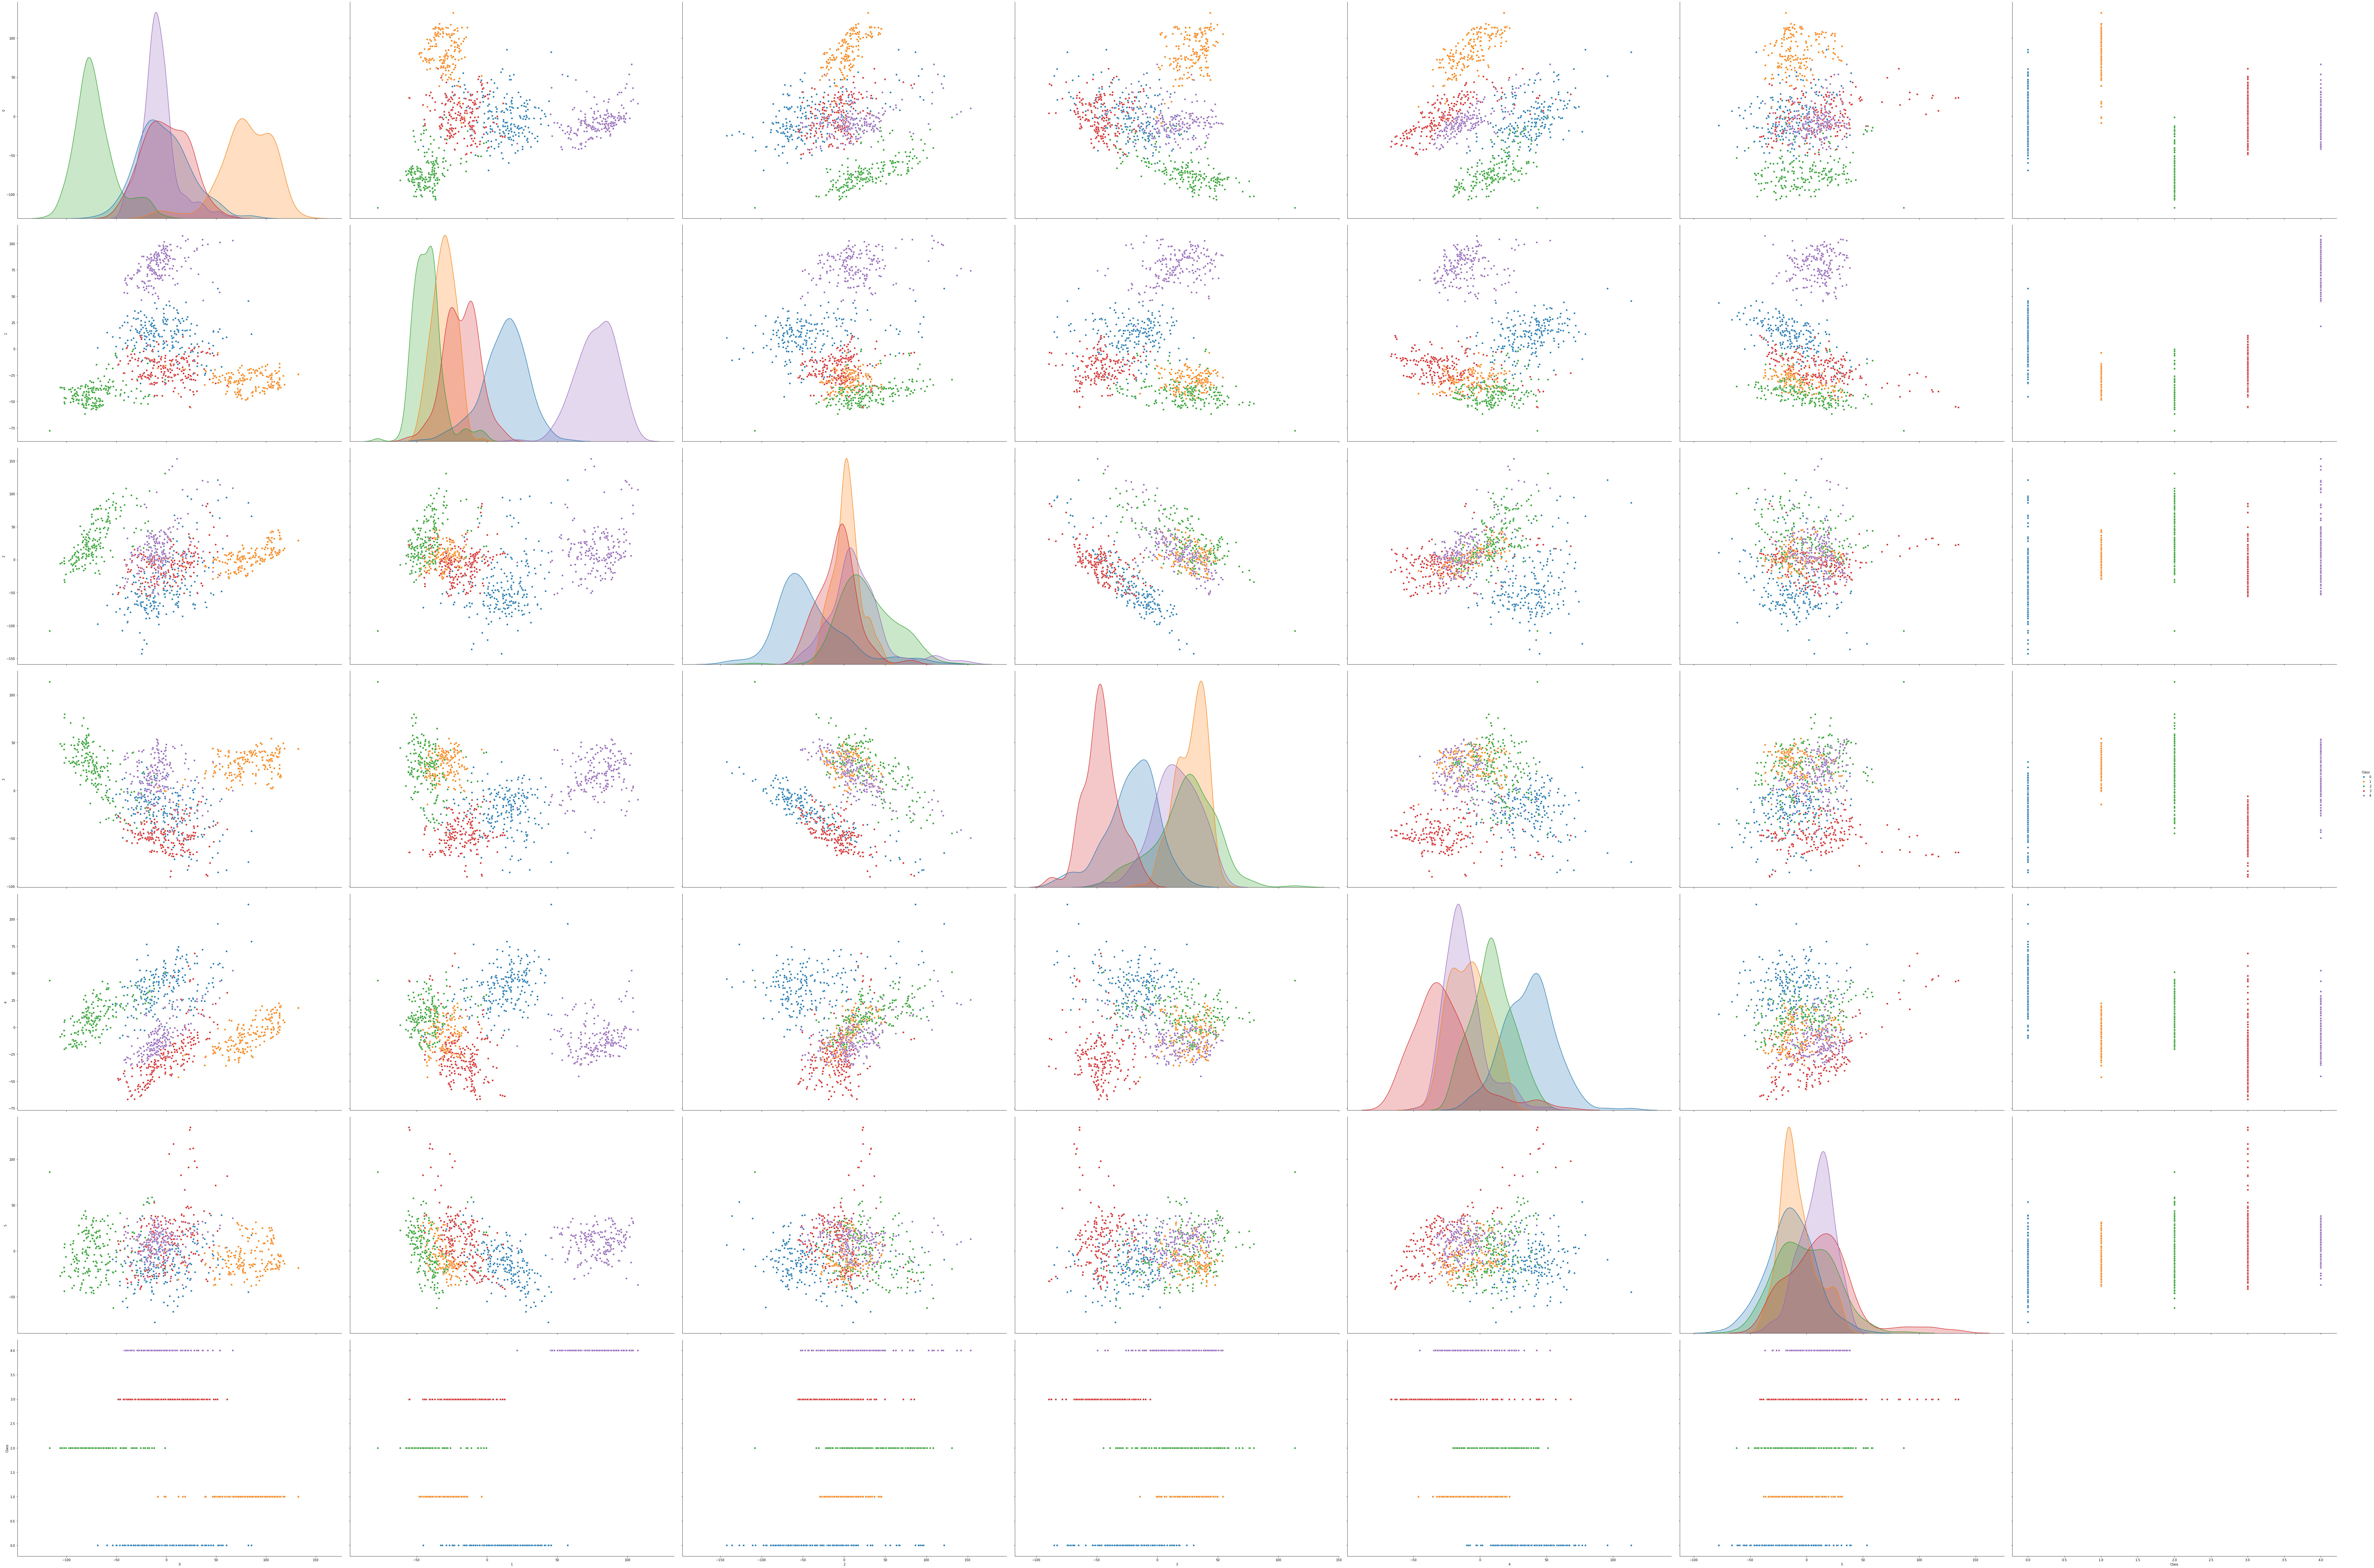

In [140]:
sns.pairplot(data=concat_df, hue="Class",size=10,aspect=1.5)
plt.show()

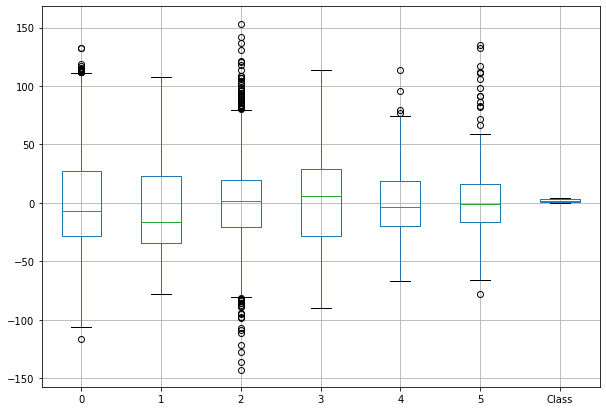

In [145]:
concat_df.boxplot(figsize= (10,7))

In [142]:
tsne = TSNE(n_components=2
            , random_state=0)
principal_component1 = tsne.fit_transform(X_train)
principal_df = pd.DataFrame(data=principal_component1)
y_train_tsne = pd.DataFrame(data = y_train, columns = ["Class"])
concat_df1 = pd.concat([principal_df, y_train_tsne], axis=1)


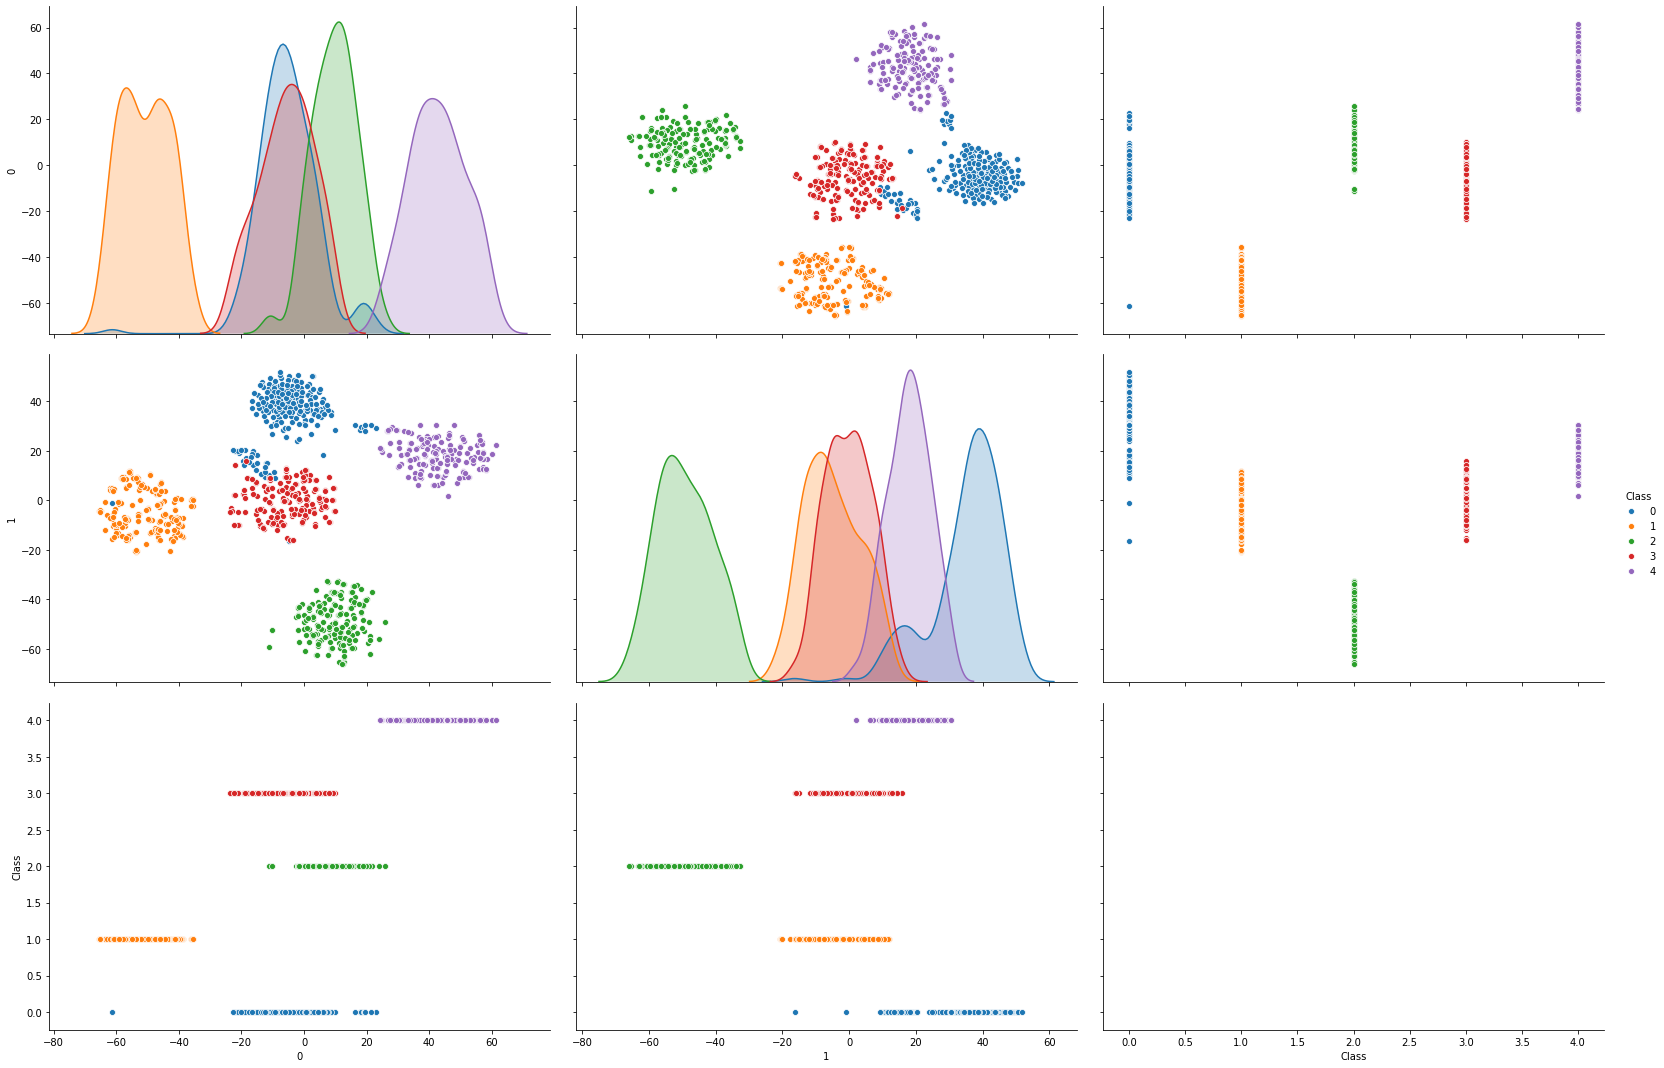

In [144]:
sns.pairplot(data=concat_df1, hue="Class",size=5,aspect=1.5)
plt.show()

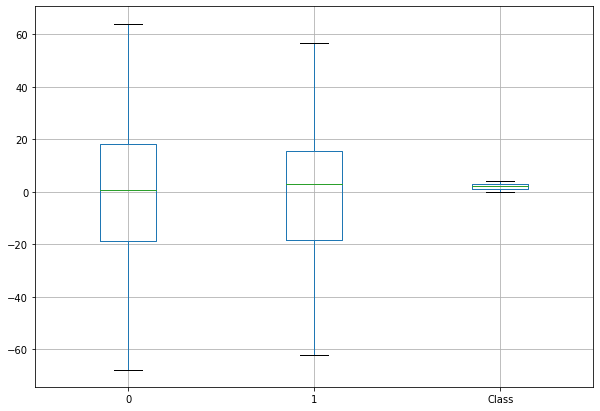

In [32]:
concat_df1.boxplot(figsize= (10,7))

In [33]:
concat_df1.head()

,0,1,Class
0,-4.947951,42.380116,0
1,1.087829,48.574974,0
2,52.662804,21.638077,4
3,-2.504642,34.356831,0
4,33.378532,14.752730,4


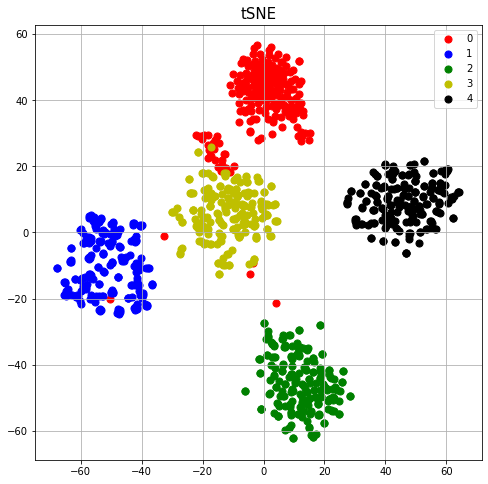

In [34]:
fig_2 = plt.figure(figsize=(8,8))
ax_2 = fig_2.add_subplot(1,1,1)
ax_2.set_title('tSNE', fontsize=15)
labels_list_2 = [0, 1, 2, 3, 4]
colors_2 = ['r', 'b', 'g', 'y', 'black']

for lab, color in zip(labels_list_2, colors_2):
    indices_2 = concat_df1['Class'] == lab
    ax_2.scatter(concat_df1.loc[indices_2, 0],
              concat_df1.loc[indices_2, 1], 
              c = color,
              s = 50)
    ax_2.legend(labels_list_2)
    ax_2.grid()

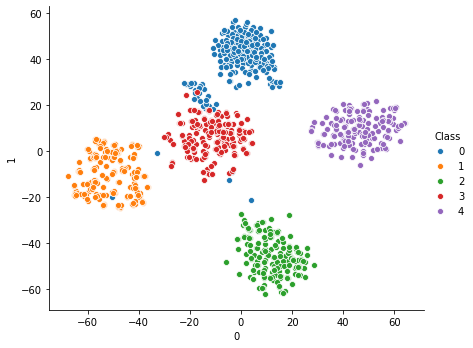

In [35]:
sns.pairplot(x_vars=0, y_vars=1, data=concat_df1, hue="Class",height=5,aspect=1.2)
plt.show()

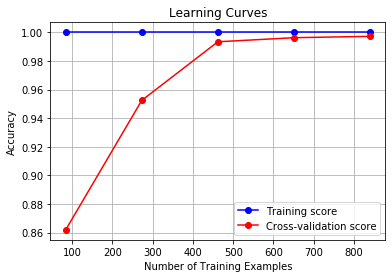

In [36]:
from sklearn.model_selection import learning_curve
classifier = DecisionTreeClassifier(criterion='entropy', presort=True, random_state=None, class_weight=None)
plt.figure()
plt.title("Learning Curves")
plt.xlabel("Number of Training Examples")
plt.ylabel("Accuracy")
plt.grid()
train_sizes, train_scores, test_scores = learning_curve(classifier, X_train, y_train, cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label="Cross-validation score")
plt.legend(loc="best")

In [146]:
X_train.shape

(1050, 20531)

## Model Selection

In [148]:
#Machine Learning Algorithm (MLA) Selection and Initialization

MLA = [
    ensemble.RandomForestClassifier(),
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),    
    DecisionTreeClassifier(),
    svm.LinearSVC()
    ]

MLA_predict = df.Class

### Principal Component Analysis

In [169]:
from sklearn.metrics import classification_report

#create table to compare MLA metrics
MLA_columns = ['Model Name','Train Accuracy Mean', 'Test Accuracy Mean','Time']
MLA_compare_pca = pd.DataFrame(columns = MLA_columns)



#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    
    MLA_compare_pca.loc[row_index, 'Model Name'] = MLA_name
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    pipe_alg = Pipeline([('pca', PCA(n_components=6)),
                         ('clf', alg)])
    
    cv_results = model_selection.cross_validate(pipe_alg, X_train, y_train, cv=5, n_jobs=-1, verbose=2, return_train_score=True)

    MLA_compare_pca.loc[row_index, 'Time'] = cv_results['fit_time'].mean()
    MLA_compare_pca.loc[row_index, 'Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare_pca.loc[row_index, 'Test Accuracy Mean'] = cv_results['test_score'].mean()   

    #save MLA predictions - see section 6 for usage
    pipe_alg.fit(X_train, y_train)
    MLA_predict[MLA_name] = pipe_alg.predict(X_test)
    y_true, y_pred = y_test, MLA_predict[MLA_name]
    #print(MLA_name)
    #print(classification_report(y_true,y_pred))
    MLA_compare_pca.loc[row_index, 'F1 Score'] = classification_report(y_true,y_pred, output_dict=True)['weighted avg']['f1-score']
    row_index+=1

    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare_pca.sort_values(by = ['F1 Score'], ascending = False, inplace = True)
MLA_compare_pca
#MLA_predict

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.1s remaining:    6.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.9s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.1s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent worker

,Model Name,Train Accuracy Mean,Test Accuracy Mean,Time,F1 Score
0,RandomForestClassifier,0.999762,0.986667,2.03958,0.966874
4,LinearSVC,0.960952,0.957143,1.57521,0.966682
2,GaussianNB,0.972381,0.972381,1.63479,0.955007
3,DecisionTreeClassifier,1,0.967619,1.57084,0.942299
1,BernoulliNB,0.93381,0.927619,1.43093,0.874988


### TSNE

In [150]:
size_train = X_train.shape[0]
X = np.vstack((X_train,X_test))
X_tsne = TSNE(n_components=2, random_state=0).fit_transform( X ) 
X_train_tsne = X_tsne[0:size_train,:]
X_test_tsne  = X_tsne[size_train:,:]

In [151]:
X_train_tsne.shape

(1050, 2)

In [170]:
from sklearn.metrics import classification_report

#create table to compare MLA metrics
MLA_columns = ['Model Name','Train Accuracy Mean', 'Test Accuracy Mean','Time']
MLA_compare_tsne = pd.DataFrame(columns = MLA_columns)



#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    
    MLA_compare_tsne.loc[row_index, 'Model Name'] = MLA_name
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    
    cv_results = model_selection.cross_validate(alg, X_train_tsne, y_train, cv=5, n_jobs=-1, verbose=2, return_train_score=True)

    MLA_compare_tsne.loc[row_index, 'Time'] = cv_results['fit_time'].mean()
    MLA_compare_tsne.loc[row_index, 'Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare_tsne.loc[row_index, 'Test Accuracy Mean'] = cv_results['test_score'].mean()   

    #save MLA predictions - see section 6 for usage
    alg.fit(X_train_tsne, y_train)
    MLA_predict[MLA_name] = alg.predict(X_test_tsne)
    y_true, y_pred = y_test, MLA_predict[MLA_name]
    #print(MLA_name)
    #print(classification_report(y_true,y_pred))
    MLA_compare_tsne.loc[row_index, 'F1 Score'] = classification_report(y_true,y_pred, output_dict=True)['weighted avg']['f1-score']
    row_index+=1
    

    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare_tsne.sort_values(by = ['F1 Score'], ascending = False, inplace = True)
MLA_compare_tsne
#MLA_predict


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
/Users/shashank/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | 

,Model Name,Train Accuracy Mean,Test Accuracy Mean,Time,F1 Score
0,RandomForestClassifier,0.99881,0.995238,0.0111216,0.991670
2,GaussianNB,0.989286,0.989524,0.00102596,0.987583
3,DecisionTreeClassifier,1,0.993333,0.000886536,0.987521
4,LinearSVC,0.985238,0.985714,0.0424388,0.987449
1,BernoulliNB,0.719048,0.719048,0.000800371,0.776218


## Hyperparameter Tuning on Random Forest Classifier

In [163]:
parameters = {'criterion':('entropy', 'gini'), 'n_estimators':[250, 500, 1000, 1500]}
rf = ensemble.RandomForestClassifier(bootstrap=True, oob_score=True, random_state=0)
clf = GridSearchCV(rf, parameters, cv=5)
clf.fit(X_train_tsne, y_train)
clf.cv_results_

{'mean_fit_time': array([0.22367725, 0.42915592, 0.85973492, 1.33638229, 0.19820199,
        0.39197755, 0.7991684 , 1.19706235]),
 'std_fit_time': array([0.01064025, 0.00807573, 0.02096463, 0.00919612, 0.00255294,
        0.00356493, 0.01619009, 0.01447931]),
 'mean_score_time': array([0.01531725, 0.02940679, 0.06191545, 0.09157777, 0.01533604,
        0.03025007, 0.06254921, 0.09066372]),
 'std_score_time': array([0.00050912, 0.000902  , 0.00345584, 0.00281414, 0.00064892,
        0.00067258, 0.00091551, 0.00100765]),
 'param_criterion': masked_array(data=['entropy', 'entropy', 'entropy', 'entropy', 'gini',
                    'gini', 'gini', 'gini'],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[250, 500, 1000, 1500, 250, 500, 1000, 1500],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=ob

In [165]:
clf.best_params_

{'criterion': 'entropy', 'n_estimators': 250}

In [166]:
clf.best_score_

0.9942857142857143

In [164]:
clf.score(X_test_tsne, y_test)

0.995850622406639

In [168]:
print(classification_report(y_test, clf.predict(X_test_tsne)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        90
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        38
           3       1.00      0.98      0.99        47
           4       1.00      1.00      1.00        41

    accuracy                           1.00       241
   macro avg       1.00      1.00      1.00       241
weighted avg       1.00      1.00      1.00       241

